In [1]:
#https://medium.com/nerd-for-tech/building-an-object-detector-in-tensorflow-using-bounding-box-regression-2bc13992973f
#https://www.pyimagesearch.com/2020/10/12/multi-class-object-detection-and-bounding-box-regression-with-keras-tensorflow-and-deep-learning/
import json
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split

In [2]:
categories = ['with_mask', 'without_mask']

f = open ('annotations.json', "r")

data = json.loads(f.read())

images  = []    # Les images d'origine
targets = []    # Les coordonnées des boxes 
labels  = []    # Les catégories des boxes  
filenames = []  # Les chemins des images


width = 180
height = 180
num_classes = len(categories)

In [3]:
# Récupérer les données depuis le json (ie les informations sur les boxes)
def load_data():
    global images, targets, labels, filenames 
    
    images = []
    targets = []
    labels = []
    filenames = []

    for i in data['data']:
        path = i['image']['path']
        we, he = Image.open(path).size # largeur et hauteur de l'image d'origine
        img = image.load_img(path,target_size=(height,width)) #L'image d'origine en taille 180/180
        img_arr = image.img_to_array(img)
        #img_arr = tf.expand_dims(img, axis=0)

        for j in i['image']['boxes']:  # On regarde les boxes correspondantes à l'image d'origine
            if(len(j)!=1):
                w = int(j['width'])
                h = int(j['height'])
                               
                category = j['category']
                
                name = j['name'].split('-')
                
                coords = name[1].split('x')
                xmin = float(coords[0].split('bb')[1]) 
                ymin = float(coords[1]) 
                xmax = float(xmin + w)  
                ymax = float(ymin + h)   

                              
                images = images + [img_arr]
                x = (xmin/we, ymin/he, xmax/we, ymax/he) # on réduit les coordonées à l'intervalle [0,1]
                targets = targets + [x]
                labels = labels + [categories.index(category)]
                filenames.append(path)



load_data()
#print(images)
#print(targets)
#print(labels)
#print(filenames)

In [4]:
train_images =  np.array(images[0:40]+images[50:90])
train_targets = np.array(targets[0:40]+targets[50:90])
train_labels =  np.array(labels[0:40]+labels[50:90])
train_filenames = np.array(filenames[0:40]+filenames[50:90])

validation_images =  np.array(images[40:50]+images[90:])
validation_targets = np.array(targets[40:50]+targets[90:])
validation_labels =  np.array(labels[40:50]+labels[90:])
validation_filenames = np.array(filenames[40:50]+filenames[90:])

In [5]:
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)
#create the base layers

base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)


classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)  

locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])


losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bb_head":tf.keras.losses.MSE}
    
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 bl_1 (Rescaling)               (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 bl_2 (Conv2D)                  (None, 180, 180, 16  448         ['bl_1[0][0]']                   
                                )                                                                 
                                                                                              

In [6]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=4,
             epochs=20,
             shuffle=True,
             verbose=1)

Epoch 1/20
20/20 [==============================] - 5s 179ms/step - loss: 1.0196 - cl_head_loss: 0.9679 - bb_head_loss: 0.0517 - cl_head_accuracy: 0.4875 - bb_head_accuracy: 0.5750 - val_loss: 0.7537 - val_cl_head_loss: 0.6934 - val_bb_head_loss: 0.0604 - val_cl_head_accuracy: 0.5000 - val_bb_head_accuracy: 0.4500
Epoch 2/20
20/20 [==============================] - 3s 156ms/step - loss: 0.7239 - cl_head_loss: 0.6865 - bb_head_loss: 0.0374 - cl_head_accuracy: 0.6875 - bb_head_accuracy: 0.5875 - val_loss: 0.7232 - val_cl_head_loss: 0.6718 - val_bb_head_loss: 0.0513 - val_cl_head_accuracy: 0.6500 - val_bb_head_accuracy: 0.6000
Epoch 3/20
20/20 [==============================] - 3s 156ms/step - loss: 0.6781 - cl_head_loss: 0.6476 - bb_head_loss: 0.0304 - cl_head_accuracy: 0.6125 - bb_head_accuracy: 0.6375 - val_loss: 0.6660 - val_cl_head_loss: 0.6198 - val_bb_head_loss: 0.0462 - val_cl_head_accuracy: 0.8000 - val_bb_head_accuracy: 0.4500
Epoch 4/20
20/20 [==============================] - 

with_mask 100 %


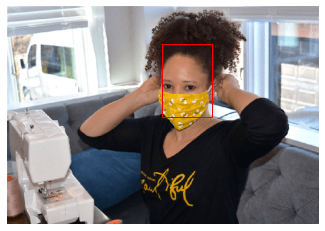

with_mask 100 %


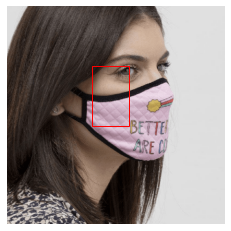

with_mask 100 %


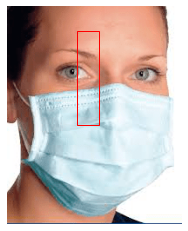

with_mask 99 %


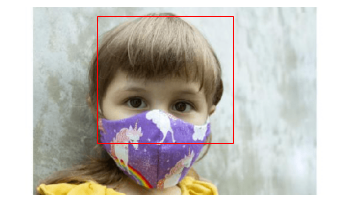

with_mask 100 %


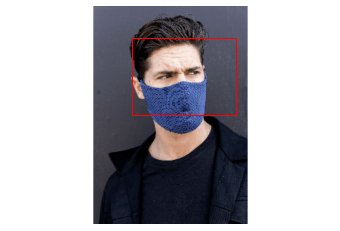

without_mask 91 %


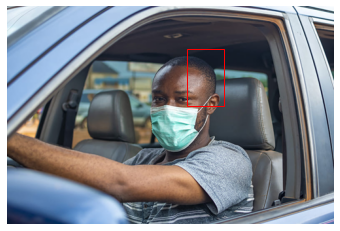

with_mask 100 %


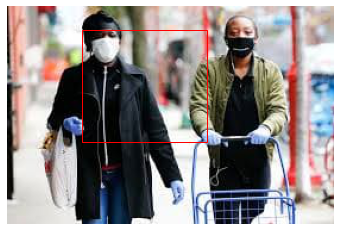

with_mask 53 %


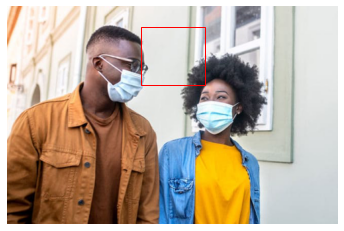

with_mask 98 %


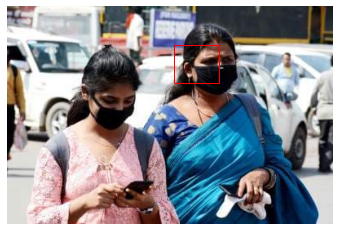

with_mask 99 %


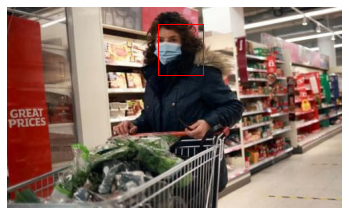

without_mask 84 %


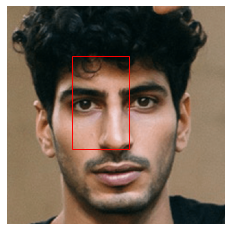

with_mask 56 %


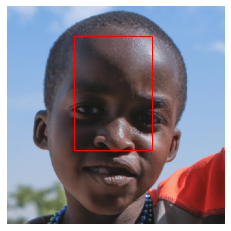

without_mask 90 %


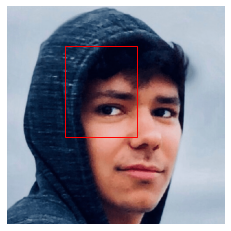

without_mask 99 %


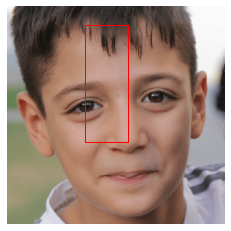

without_mask 62 %


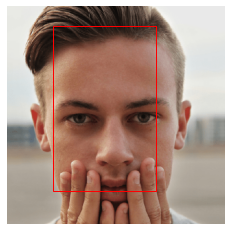

without_mask 100 %


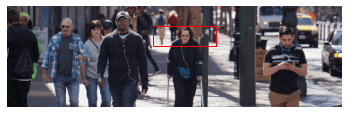

without_mask 99 %


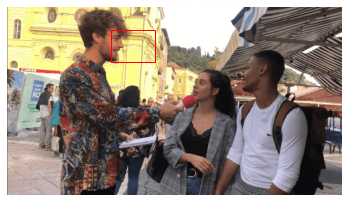

without_mask 91 %


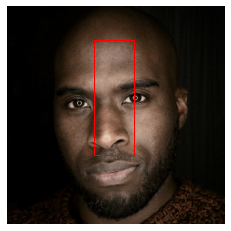

with_mask 100 %


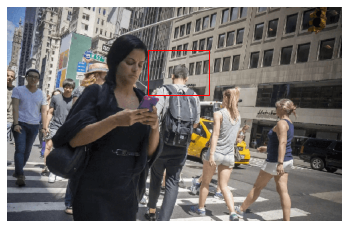

without_mask 89 %


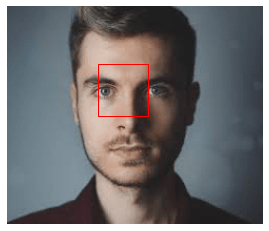

Accuracy :  0.85


In [7]:
predictions = model.predict(validation_images)
#print(predictions)

accuracy = 0

for nb_image in range(len(validation_images)):
    
    fig, ax = plt.subplots()

    img = Image.open(validation_filenames[nb_image]) # On ouvre l'image avec sa taille originale
    we, he = img.size  # largeur et hauteur de l'image initiale
    ax.imshow(img) # on affiche l'image
    
    classes_predcitions = predictions[0][nb_image] # les prédictions des classes
    boxes_predictions = predictions[1][nb_image] # les prédictions des boites
    
    # On repasse des coordonnées dans [0,1] aux coordonnées dans [largeur image, hauteur image] 
    xmin = boxes_predictions[0] * we 
    ymin = boxes_predictions[1] * he
    xmax = boxes_predictions[2] * we 
    ymax = boxes_predictions[3] * he
    
    w = abs(xmax-xmin) # largeur de la boite
    h = abs(ymax-ymin) # hauteur de la boite
    
    # determination de la categorie : 
    probas = tf.nn.softmax(classes_predcitions)
    pourcentage = int(round(100*np.max(probas), 0))
    category_predicted = categories[np.argmax(probas)] 

    print(category_predicted, pourcentage, "%")
    
        
    if (np.argmax(probas) == validation_labels[nb_image]):
        accuracy = accuracy + 1

    ax.add_patch(Rectangle((xmin,ymin), w, h,linewidth=1,edgecolor='r',facecolor='none')) # le dessin de la boite
    
    plt.axis('off')  # si on veut enlever les graduations des axes
    plt.show()
    
print("Accuracy : ", accuracy/len(validation_images) )


In [8]:
def prediction_function(file, mode):
    
    try:
        nb_image = list(validation_filenames).index(file)
        predictions = model.predict(validation_images)
      
        if mode=='category':
            category_predicted = categories[np.argmax(tf.nn.softmax(predictions[0][nb_image]))]
            print(" The predicted category is :  ", category_predicted )

        elif mode=='probabilities':
            proba_with_mask = int(round(100*np.max((tf.nn.softmax(predictions[0][nb_image]))[0]),0))
            proba_without_mask =  int(round(100*np.max((tf.nn.softmax(predictions[0][nb_image]))[1]),0))

            print(" Probability for the category with_mask     : " , proba_with_mask , "%")
            print(" Probability for the category without_mask  : " , proba_without_mask ,"%")
            

    except ValueError:
        print("Warning : the file name or the mode name contains an error.")
        
prediction_function("../img/resized/without_mask/image99.png","probabilities")

 Probability for the category with_mask     :  11 %
 Probability for the category without_mask  :  89 %
